# Latent Feature Extraction

## 1. Set up the Environment

In [ ]:
!python -c "import monai" || pip install -q "monai-weekly[nibabel, tqdm]"

Traceback (most recent call last):
  File "<string>", line 1, in <module>
ModuleNotFoundError: No module named 'monai'
     |████████████████████████████████| 1.2 MB 30.5 MB/s 


In [ ]:
import logging
import os
import sys
import shutil
import tempfile
import random
import time
import copy

import matplotlib.pyplot as plt
import torch
from torch.utils.tensorboard import SummaryWriter
import numpy as np
import pandas as pd

import monai
from monai.apps import download_and_extract
from monai.config import print_config
from monai.data import DataLoader, CacheDataset, partition_dataset_classes

from monai.transforms import (
    Compose,
    ScaleIntensityRanged,
    EnsureTyped,
    LoadImaged,
    AddChanneld,
    Orientationd,
    Resized,
    EnsureType,
    Activations,
    AsDiscrete
)

In [ ]:
device = torch.device("cuda")

In [ ]:
# set a random seed for reproducibility
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

seed_everything(123)

## 2. Connect to Google Colab

In [ ]:
from google.colab import drive
drive.mount('/content/drive',force_remount = True)

drive_dir = "/content/drive/My Drive"
mount_dir = os.path.join(drive_dir, "Colab Notebooks")
image_dir = os.path.join(mount_dir, "nnUNet_raw_data_base/nnUNet_raw_data/T2_test_data/imagesTs")
weights_dir = os.path.join(mount_dir, "pretrained_models/MedicalNet_resnet")
results_dir = os.path.join(drive_dir, "Test Data")

Mounted at /content/drive


## 3. Create Train and Validation Dataset

In [ ]:
# specify transformations that are to be applied
transforms = Compose([
    LoadImaged(keys=["image"]),
    AddChanneld(keys=["image"]),
    Orientationd(keys=["image"], axcodes="PLI"),
    Resized(keys=["image"], spatial_size=(128, 128, 64)),
    ScaleIntensityRanged(keys=['image'], a_min=0, a_max=255, b_min=0.0, b_max=1.0, clip=True),
    EnsureTyped(keys=["image"])])

/usr/local/lib/python3.8/dist-packages/monai/utils/deprecate_utils.py:107: FutureWarning: <class 'monai.transforms.utility.array.AddChannel'>: Class `AddChannel` has been deprecated since version 0.8. please use MetaTensor data type and monai.transforms.EnsureChannelFirst instead.
  warn_deprecated(obj, msg, warning_category)


In [ ]:
# Create labels
labels = np.concatenate((np.ones(20, dtype='int64'), np.zeros(20, dtype='int64')), axis=0)

# Get image paths
image_paths = [
  os.path.join(image_dir, img)
  for img in os.listdir(image_dir)
]

data = [{"image": i, "label": l} for i, l in zip(image_paths, labels)]

In [ ]:
# create 80:20 data split
data_partition = partition_dataset_classes(data, labels.tolist(), shuffle=True, ratios=[0.8, 0.2])

# create data loader object
datasets = {x: CacheDataset(data=data_partition[x], transform=transforms) for x in [0, 1]}
dataloaders_dict = {x: DataLoader(datasets[x], batch_size=8, shuffle=True, num_workers=4) for x in [0, 1]}

# rename dict of data loader object
dataloaders_dict['train'] = dataloaders_dict.pop(0)
dataloaders_dict['val'] = dataloaders_dict.pop(1)

Loading dataset: 100%|██████████| 8/8 [00:14<00:00,  1.82s/it]
/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py:554: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


## 4. Define Network Architecture

In [ ]:
class ResNet50(torch.nn.Module):
    def __init__(self, num_classes, pretrained = False, features_extract = False):
        super().__init__()

        # load 3d ResNet
        self.model = monai.networks.nets.resnet50(spatial_dims=3, n_input_channels=1)
        if pretrained:
          model_dict = self.model.state_dict()

          # load pretrained MedicalNet weights
          weights_dict = torch.load(os.path.join(weights_dir, "resnet_50_23dataset.pth"))
          
          # rename modules in weight dict
          weights_dict = {k.replace('module.', ''): v for k, v in weights_dict['state_dict'].items()}

          # update model weights with pretrained weights
          model_dict.update(weights_dict)
          self.model.load_state_dict(model_dict)
        
        # freeze model weights
        if features_extract:
          conv_block = 0
          for child in self.model.children():
            conv_block += 1
            if conv_block < 8:
              for param in child.parameters():
                param.requires_grad = False
            #elif conv_block == 8:
             # layer = 0
              #for children_of_child in child.children():
               # layer += 1
                #if layer < 3:
                 # for param in children_of_child.parameters():
                  #  param.requires_grad = False

        # create custom fc layers
        num_ftrs = self.model.fc.in_features
        self.model.fc = torch.nn.Identity()

        self.features = torch.nn.Linear(num_ftrs, 128)
        self.classifier = torch.nn.Linear(128, num_classes)
    
    def forward(self, image):

        # define forward pass
        x = self.model(image)
        x = self.features(x)
        x = self.classifier(x)
        
        return x

## 5. Initialize the Network with Pretrained Weights

In [ ]:
# Number of classes in the dataset
num_classes = 2

# Flag to indicate whether model should be initialized with pretrained weights
pretrained = True

# Flag to indicate whether only a set of weights should be updated. If False
# the entire model is finetuned
feature_extract = True

In [ ]:
# Initialize the model for this run
model_ft = ResNet50(num_classes, pretrained, feature_extract)

# add model to GPU
model_ft = model_ft.to(device)

## 6. Specify Parameters that Should Be Finetuned  

In [ ]:
# Gather the parameters to be optimized/updated in this run
params_to_update = model_ft.parameters()
print("Params to learn:")
if feature_extract:
    params_to_update = []
    for name,param in model_ft.named_parameters():
        if param.requires_grad == True:
            params_to_update.append(param)
            print("\t",name)
else:
    for name,param in model_ft.named_parameters():
        if param.requires_grad == True:
            print("\t",name)

Params to learn:
	 model.layer4.0.conv1.weight
	 model.layer4.0.bn1.weight
	 model.layer4.0.bn1.bias
	 model.layer4.0.conv2.weight
	 model.layer4.0.bn2.weight
	 model.layer4.0.bn2.bias
	 model.layer4.0.conv3.weight
	 model.layer4.0.bn3.weight
	 model.layer4.0.bn3.bias
	 model.layer4.0.downsample.0.weight
	 model.layer4.0.downsample.0.bias
	 model.layer4.0.downsample.1.weight
	 model.layer4.0.downsample.1.bias
	 model.layer4.1.conv1.weight
	 model.layer4.1.bn1.weight
	 model.layer4.1.bn1.bias
	 model.layer4.1.conv2.weight
	 model.layer4.1.bn2.weight
	 model.layer4.1.bn2.bias
	 model.layer4.1.conv3.weight
	 model.layer4.1.bn3.weight
	 model.layer4.1.bn3.bias
	 model.layer4.2.conv1.weight
	 model.layer4.2.bn1.weight
	 model.layer4.2.bn1.bias
	 model.layer4.2.conv2.weight
	 model.layer4.2.bn2.weight
	 model.layer4.2.bn2.bias
	 model.layer4.2.conv3.weight
	 model.layer4.2.bn3.weight
	 model.layer4.2.bn3.bias
	 features.weight
	 features.bias
	 classifier.weight
	 classifier.bias


## 7. Finetune the Network

In [ ]:
# Specify the loss function
criterion = torch.nn.CrossEntropyLoss()

# Specify the learning rate
optimizer_ft = torch.optim.SGD(params_to_update, lr=0.001, momentum=0.9)

In [ ]:
def train_model(model, dataloaders, criterion, optimizer, min_epochs=50, early_stop=False):
    since = time.time()

    # create empty storage
    train_loss_history = []
    train_acc_history = []
    val_loss_history = []
    val_acc_history = []

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    best_loss = 10000.0
    counter = 0

    for epoch in range(min_epochs + 10 * min_epochs):
        print('Epoch {}'.format(epoch))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for batch_data in dataloaders[phase]:
                inputs, labels = batch_data["image"].to(device), batch_data["label"].to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    loss = criterion(outputs, labels)

                    _, preds = torch.max(outputs, 1)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / len(dataloaders[phase].dataset)
            epoch_acc = running_corrects.double() / len(dataloaders[phase].dataset)

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc.item()))

            # safe training loss and accuracy
            if phase == 'train':
                train_loss_history.append(epoch_loss)
                train_acc_history.append(epoch_acc)

            # deep copy the model
            if phase == 'val' and epoch_loss < best_loss:
                best_loss = epoch_loss
                best_acc = epoch_acc
                counter = 0
                best_model_wts = copy.deepcopy(model.state_dict())
            elif phase == 'val' and epoch_loss >= best_loss:
                counter += 1

            # safe validation loss and accuracy
            if phase == 'val':
                val_loss_history.append(epoch_loss)
                val_acc_history.append(epoch_acc) 

        print()

        # introduce early stopping
        if early_stop:
            if epoch > min_epochs - 1 and counter == 10:
                break

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc.item()))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model, val_loss_history, val_acc_history, train_loss_history, train_acc_history

In [ ]:
# Minimum number of epochs to train for
min_epochs = 50

# Flag to indicate whether early stopping should be used
early_stop = True

In [ ]:
# Train and evaluate
model_ft, val_loss_hist, val_acc_hist, train_loss_hist, train_acc_hist = train_model(model_ft, dataloaders_dict, criterion, optimizer_ft, min_epochs=min_epochs, early_stop=early_stop)

Epoch 0
----------
train Loss: 0.7060 Acc: 0.5000
val Loss: 0.6959 Acc: 0.5000

Epoch 1
----------
train Loss: 0.7017 Acc: 0.5000
val Loss: 0.6937 Acc: 0.5000

Epoch 2
----------
train Loss: 0.7070 Acc: 0.5000
val Loss: 0.6934 Acc: 0.5000

Epoch 3
----------
train Loss: 0.6989 Acc: 0.5000
val Loss: 0.6931 Acc: 0.5000

Epoch 4
----------
train Loss: 0.6845 Acc: 0.5312
val Loss: 0.6932 Acc: 0.5000

Epoch 5
----------
train Loss: 0.6947 Acc: 0.5312
val Loss: 0.6930 Acc: 0.5000

Epoch 6
----------
train Loss: 0.6931 Acc: 0.5312
val Loss: 0.6936 Acc: 0.5000

Epoch 7
----------
train Loss: 0.6877 Acc: 0.5000
val Loss: 0.6929 Acc: 0.5000

Epoch 8
----------
train Loss: 0.6832 Acc: 0.6250
val Loss: 0.6928 Acc: 0.5000

Epoch 9
----------
train Loss: 0.6838 Acc: 0.6250
val Loss: 0.6929 Acc: 0.5000

Epoch 10
----------
train Loss: 0.6756 Acc: 0.6250
val Loss: 0.6932 Acc: 0.5000

Epoch 11
----------
train Loss: 0.6907 Acc: 0.5000
val Loss: 0.6924 Acc: 0.5000

Epoch 12
----------
train Loss: 0.6768

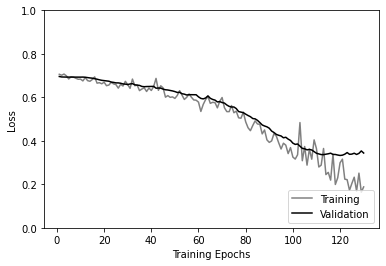

In [ ]:
# Plot the training curves of validation accuracy vs. number of training epochs 
train_loss = []
train_loss = [epoch for epoch in train_loss_hist]

val_loss = []
val_loss = [epoch for epoch in val_loss_hist]

#plt.title("Validation Accuracy vs. Number of Training Epochs")
plt.xlabel("Training Epochs")
plt.ylabel("Loss")
plt.plot(range(1, 131), train_loss, color="grey", label="Training")
plt.plot(range(1, 131), val_loss, color="black", label="Validation")
plt.ylim((0,1.))
plt.xticks(np.arange(0, 131, 20))
plt.legend(loc="lower right")

plt.savefig(os.path.join(results_dir, 'loss_hist.png'), dpi=300)

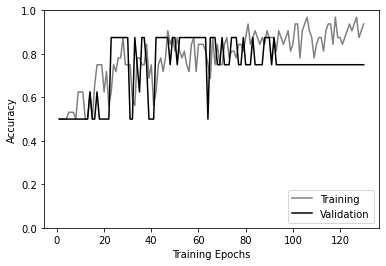

In [ ]:
# Plot the training curves of validation accuracy vs. number of training epochs 
train_acc = []
train_acc = [epoch.cpu().numpy() for epoch in train_acc_hist]

val_acc = []
val_acc = [epoch.cpu().numpy() for epoch in val_acc_hist]

#plt.title("Training Loss vs. Number of Training Epochs")
plt.xlabel("Training Epochs")
plt.ylabel("Accuracy")
plt.plot(range(1, 131), train_acc, color="grey", label="Training")
plt.plot(range(1, 131), val_acc, color="black", label="Validation")
plt.ylim((0,1.))
plt.xticks(np.arange(0, 131, 20))
plt.legend(loc="lower right")

plt.savefig(os.path.join(results_dir, 'acc_hist.png'), dpi=300)

## 8. Extract Latent Features from Finetuned Model

In [ ]:
def get_features(name):
    def hook(model, input, output):
        features[name] = output.detach()
    return hook

In [ ]:
# set hook at layer where features should be extracted
model_ft.features.register_forward_hook(get_features('feats'))

In [ ]:
# placeholders
labels = []
pred = []
feats = []
img_path = []

# placeholder for batch features
features = {}

# loop through batches
for phase in ['train', 'val']:
  for batch_data in dataloaders_dict[phase]:
    # move to device
    fname = batch_data["image_meta_dict"]["filename_or_obj"]
    inputs = batch_data["image"].to(device)
    targets = batch_data["label"].to(device)
       
    # forward pass [with feature extraction]
    preds = model_ft(inputs)
    
    # add feats and preds to lists
    img_path.extend(fname)
    labels.append(targets.detach().cpu().numpy())
    feats.append(features['feats'].cpu().numpy())

In [ ]:
feats_ft = np.concatenate(feats)
feats_ft.shape # 128 features

(40, 128)

In [ ]:
labels_ft = np.concatenate(labels)
labels_ft.shape

(40,)

In [ ]:
img_path = [path.replace(image_dir + '/', '') for path in img_path]
img_path = [path.replace('_0000.nii.gz', '') for path in img_path]

## 9. Write Feature Matrix to csv File

In [ ]:
# merge labels and features into a dataframe
ids = pd.DataFrame(img_path, columns=['id'])
labels = pd.DataFrame(labels_ft, columns=['HCC'])
deep_feats = pd.DataFrame(feats_ft, 
                          columns = ["var%d" % (i + 1) 
                          for i in range(feats_ft.shape[1])])

deep_feats = pd.concat([ids.reset_index(drop=True), labels, deep_feats], axis=1)

# write dataframe to csv
deep_feats.to_csv(os.path.join(results_dir, 'DeepFeaturesNew.csv'), index=False, header=True, sep=',')